In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
#Importing necessary dependencies
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from numpy import dstack
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
class Config:
    input_shape = (7,7,1)
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_classes = 10
    num_epochs = 100
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [4]:
d1 = pd.read_csv('/content/UNSW_NB15_training-set.csv')
t1 = pd.read_csv('/content/UNSW_NB15_testing-set.csv')

In [5]:
data = d1.append(t1, ignore_index = True)
from sklearn import preprocessing
data.drop(columns = 'label', inplace = True)
multic = pd.DataFrame(data.attack_cat)
le2 = preprocessing.LabelEncoder()
enc_label = multic.apply(le2.fit_transform)
data['attax'] = enc_label
categorical_features = ['proto', 'service', 'state']
label_feature = ['attack_cat', 'attax']

In [6]:
drop_features = ['id', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
numerical_features = list(set(data.columns) - set(label_feature) - set(categorical_features) - set(drop_features))

In [7]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
data.drop(columns = categorical_features, inplace = True)

In [8]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
Y = data['attax']
X = data.drop(columns = ['attax', 'attack_cat'], axis = 1)

In [10]:
!pip install tab2img
from tab2img.converter import Tab2Img
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled_train = scaler.transform(X)
y_scaler =  preprocessing.StandardScaler().fit(Y.values.reshape(-1, 1))
y_scaled_train = y_scaler.transform(Y.values.reshape(-1, 1))
model = Tab2Img()
train_images = model.fit_transform(X_scaled_train, y_scaled_train)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from tensorflow.keras import Model, optimizers
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
import sklearn
from sklearn.model_selection import train_test_split

In [12]:
new_shape = (train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
Y = tf.keras.utils.to_categorical(Y)
train_images = train_images.reshape(new_shape)

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_images, Y, random_state=10, test_size=0.2)

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(7, 7, 1)
(1, 72, 72, 1)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


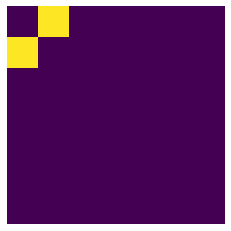

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_data[np.random.choice(range(train_data.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

In [17]:
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [18]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)
    
    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads, 
            key_dim=Config.projection_dim,
            dropout=0.2
        )(x1, x1)
        # Skip Connnection 1
        x2 = layers.Add()([attention_output, encoder_patches])
        
        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.2)
        
        # Skip Connnection 2
        encoder_patches = layers.Add()([x3, x2])
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    
    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.3)
    
    outputs = layers.Dense(Config.num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [21]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 1)]    0           []                               
                                                                                                  
 sequential (Sequential)        (None, 72, 72, 1)    3           ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 36)     0           ['sequential[0][0]']             
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      11584       ['patches[0][0]']                
                                                                                              

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


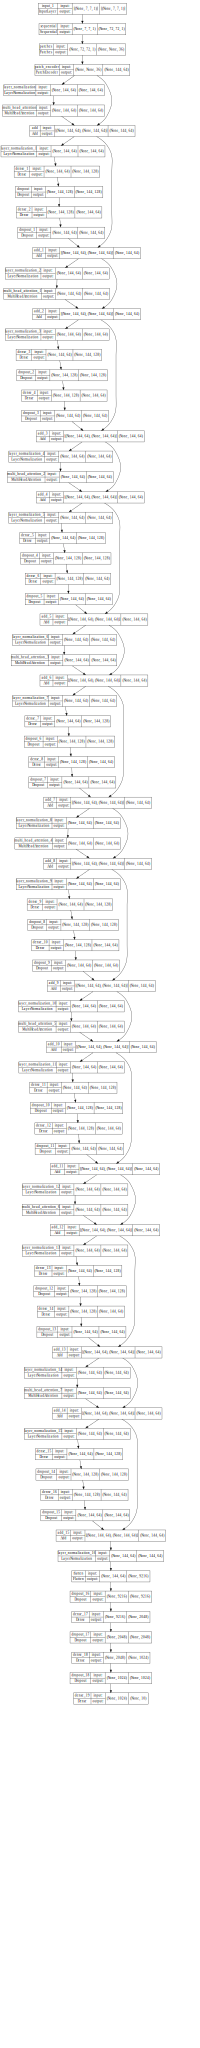

In [22]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
!apt-get -qq install -y graphviz && pip install pydot
import pydot
import graphviz

SVG(model_to_dot(vit_classifier, show_shapes=True, show_layer_names=True, rankdir='TB',
    expand_nested=False, dpi=60, subgraph=False
).create(prog='dot',format='svg'))